In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!wandb login 9676e3cc95066e4865586082971f2653245f09b4

wandb: Appending key for api.wandb.ai to your netrc file: /Users/guydavidson/.netrc
Successfully logged in to Weights & Biases!


In [3]:
import copy
from collections import defaultdict, namedtuple
from datetime import datetime
import itertools
import os
from pathlib import Path
import pickle

import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.special import factorial

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath
import matplotlib.gridspec as gridspec

import tabulate
import wandb
from tqdm.notebook import tqdm

In [4]:
api = wandb.Api()

In [40]:
FIGURE_TEMPLATE = r'''\begin{{figure}}[!htb]
% \vspace{{-0.225in}}
\centering
\includegraphics[width=\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
% \vspace{{-0.2in}}
\end{{figure}}
'''
WRAPFIGURE_TEMPLATE = r'''\begin{{wrapfigure}}{{r}}{{0.5\linewidth}}
\vspace{{-.3in}}
\begin{{spacing}}{{1.0}}
\centering
\includegraphics[width=0.95\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
\end{{spacing}}
% \vspace{{-.25in}}
\end{{wrapfigure}}'''

SAVE_PATH_PREFIX = 'figures'


def save_plot(save_path, bbox_inches='tight', should_print=False):
    if save_path is not None:
        save_path_no_ext = os.path.splitext(save_path)[0]
        if should_print:
            print('Figure:\n')
            print(FIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
            print('\nWrapfigure:\n')
            print(WRAPFIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
            print('')
        
        if not save_path.startswith(SAVE_PATH_PREFIX):
            save_path = os.path.join(SAVE_PATH_PREFIX, save_path)
        
        folder, filename = os.path.split(save_path)
        os.makedirs(folder, exist_ok=True)
        plt.savefig(save_path, bbox_inches=bbox_inches, facecolor=plt.gcf().get_facecolor(), edgecolor='none')

In [6]:
Condition = namedtuple('Condition', ('relation', 'model_config', 'num_objects', 'dataset_size', 'dataset_power'))

In [7]:
CACHE_PATH = './results_cache.pickle'
BACKUP_CACHE_PATH = './results_cache_{date}.pickle'


def refresh_cache(new_values_dict=None, cache_path=CACHE_PATH):
    if new_values_dict is None:
        new_values_dict = {}
    
    if os.path.exists(cache_path):
        with open(cache_path, 'rb') as cache_file:
            cache = pickle.load(cache_file)
    
    else:
        cache = {}
    
    cache.update(new_values_dict)
    
    if os.path.exists(cache_path):
        os.rename(CACHE_PATH, BACKUP_CACHE_PATH.format(date=datetime.now().strftime('%Y-%m-%d_%H-%M-%S')))

    with open(cache_path, 'wb') as cache_file:
        pickle.dump(cache, cache_file)

    return cache
 

cache = refresh_cache()

In [8]:
print(cache.keys())

dict_keys(['all_results', 'all_results_df', 'all_results_fixed_checkpoints', 'all_results_fixed_checkpoints_df'])


# Game plan
* Iterate through projects 
* Parse each project conditions from its name
* Aggregate each of the following statistics by model:
    * Peak accuracy
    * Epoch in which peak accuracy takes place
    * Epoch above some accuracy threshold
    * Did the model overfit (delta between train and val?)
* Start examining the effects of different manipulations:
    * Choice of relation
    * Number of objects
    * Size of the training set
    * Size of the model (in that one condition I ran larger)
* Probably more bar charts tables than anything else, unless we need learning curves



In [22]:
def name_to_condition(name):
    relation, model_config, num_objects, dataset_size = name.split('-')[::2]
    num_objects = int(num_objects)
    dataset_size = int(dataset_size)
    return Condition(relation=relation, model_config=model_config, num_objects=num_objects, 
                     dataset_size=dataset_size, dataset_power=int(np.log2(dataset_size)))


def parse_run(run, num_samples=10000, accuracy_threshold=0.95):
    history_df = run.history(samples=num_samples)
    run_results = {}
    
    max_accuracy_index = history_df.val_acc.idxmax()
    run_results['max_val_acc'] = history_df.val_acc[max_accuracy_index]
    run_results['max_val_acc_step'] = history_df.global_step[max_accuracy_index]
    
    accuracy_above_treshold_index = (history_df.val_acc >= accuracy_threshold).idxmax()
    if accuracy_above_treshold_index == 0:  # Never went above treshold
        run_results['acc_threshold_step'] = None
    else:
        run_results['acc_threshold_step'] = history_df.global_step[accuracy_above_treshold_index]
        
    run_results['acc_diff'] = history_df.train_acc.max() - history_df.val_acc.max()
    
    return run_results
    
    
def parse_project(project):
    uri = f'{project.entity}/{project.name}'
    runs = api.runs(uri)
    results_by_model = defaultdict(list)
    
    for run in tqdm(runs, desc='Runs'):
        seed_split_index = run.name.rindex('-')
        model_name = run.name[:seed_split_index]
        seed = int(run.name[seed_split_index + 1:])
        
        run_results = parse_run(run)
        run_results['seed'] = seed
        run_results['total_params'] = run.config['total_params']
        
        results_by_model[model_name].append(run_results)
        
    return results_by_model
        
        
def parse_all_projects(entity='simple-relational-reasoning'):
    projects = api.projects(entity)
    results = {}
    
    print(projects)
    for proj in tqdm([p for p in projects], desc='Projects'):
        condition = name_to_condition(proj.name)
#         print(proj.name)
#         print(condition)
        results[condition] = parse_project(proj)
        
    return results


if 'all_results' not in cache:
    cache['all_results'] = parse_all_projects()
    cache = refresh_cache(cache)
    
all_results = cache['all_results']

In [23]:
if 'all_results_fixed_checkpoints' not in cache:
    cache['all_results_fixed_checkpoints'] = parse_all_projects(entity='simple-relational-reasoning-fixed-checkpoints')
    cache = refresh_cache(cache)
    
all_results_fixed_checkpoints = cache['all_results_fixed_checkpoints']

<Projects simple-relational-reasoning-fixed-checkpoints>


between-relation-larger-models-10-objects-65536-dataset
Condition(relation='between', model_config='larger', num_objects=10, dataset_size=65536, dataset_power=16)



count-relation-larger-models-10-objects-65536-dataset
Condition(relation='count', model_config='larger', num_objects=10, dataset_size=65536, dataset_power=16)



above-relation-larger-models-10-objects-65536-dataset
Condition(relation='above', model_config='larger', num_objects=10, dataset_size=65536, dataset_power=16)



adjacent-relation-larger-models-10-objects-65536-dataset
Condition(relation='adjacent', model_config='larger', num_objects=10, dataset_size=65536, dataset_power=16)



between-relation-larger-models-5-objects-65536-dataset
Condition(relation='between', model_config='larger', num_objects=5, dataset_size=65536, dataset_power=16)



count-relation-larger-models-5-objects-65536-dataset
Condition(relation='count', model_config='larger', num_objects=5, dataset_size=65536, dataset_power=16)



above-relation-larger-models-5-objects-65536-dataset
Condition(relation='above', model_config='larger', num_objects=5, dataset_size=65536, dataset_power=16)



adjacent-relation-larger-models-5-objects-65536-dataset
Condition(relation='adjacent', model_config='larger', num_objects=5, dataset_size=65536, dataset_power=16)



between-relation-default-models-10-objects-65536-dataset
Condition(relation='between', model_config='default', num_objects=10, dataset_size=65536, dataset_power=16)



count-relation-default-models-10-objects-65536-dataset
Condition(relation='count', model_config='default', num_objects=10, dataset_size=65536, dataset_power=16)



above-relation-default-models-10-objects-65536-dataset
Condition(relation='above', model_config='default', num_objects=10, dataset_size=65536, dataset_power=16)



adjacent-relation-default-models-10-objects-65536-dataset
Condition(relation='adjacent', model_config='default', num_objects=10, dataset_size=65536, dataset_power=16)



between-relation-default-models-5-objects-65536-dataset
Condition(relation='between', model_config='default', num_objects=5, dataset_size=65536, dataset_power=16)



count-relation-default-models-5-objects-65536-dataset
Condition(relation='count', model_config='default', num_objects=5, dataset_size=65536, dataset_power=16)



above-relation-default-models-5-objects-65536-dataset
Condition(relation='above', model_config='default', num_objects=5, dataset_size=65536, dataset_power=16)



adjacent-relation-default-models-5-objects-65536-dataset
Condition(relation='adjacent', model_config='default', num_objects=5, dataset_size=65536, dataset_power=16)



between-relation-default-models-10-objects-16384-dataset
Condition(relation='between', model_config='default', num_objects=10, dataset_size=16384, dataset_power=14)



count-relation-default-models-10-objects-16384-dataset
Condition(relation='count', model_config='default', num_objects=10, dataset_size=16384, dataset_power=14)



above-relation-default-models-10-objects-16384-dataset
Condition(relation='above', model_config='default', num_objects=10, dataset_size=16384, dataset_power=14)



adjacent-relation-default-models-10-objects-16384-dataset
Condition(relation='adjacent', model_config='default', num_objects=10, dataset_size=16384, dataset_power=14)



between-relation-default-models-5-objects-16384-dataset
Condition(relation='between', model_config='default', num_objects=5, dataset_size=16384, dataset_power=14)



count-relation-default-models-5-objects-16384-dataset
Condition(relation='count', model_config='default', num_objects=5, dataset_size=16384, dataset_power=14)



above-relation-default-models-5-objects-16384-dataset
Condition(relation='above', model_config='default', num_objects=5, dataset_size=16384, dataset_power=14)



adjacent-relation-default-models-5-objects-16384-dataset
Condition(relation='adjacent', model_config='default', num_objects=5, dataset_size=16384, dataset_power=14)



between-relation-default-models-10-objects-4096-dataset
Condition(relation='between', model_config='default', num_objects=10, dataset_size=4096, dataset_power=12)



count-relation-default-models-10-objects-4096-dataset
Condition(relation='count', model_config='default', num_objects=10, dataset_size=4096, dataset_power=12)



above-relation-default-models-10-objects-4096-dataset
Condition(relation='above', model_config='default', num_objects=10, dataset_size=4096, dataset_power=12)



adjacent-relation-default-models-10-objects-4096-dataset
Condition(relation='adjacent', model_config='default', num_objects=10, dataset_size=4096, dataset_power=12)



between-relation-default-models-5-objects-4096-dataset
Condition(relation='between', model_config='default', num_objects=5, dataset_size=4096, dataset_power=12)



count-relation-default-models-5-objects-4096-dataset
Condition(relation='count', model_config='default', num_objects=5, dataset_size=4096, dataset_power=12)



above-relation-default-models-5-objects-4096-dataset
Condition(relation='above', model_config='default', num_objects=5, dataset_size=4096, dataset_power=12)



adjacent-relation-default-models-5-objects-4096-dataset
Condition(relation='adjacent', model_config='default', num_objects=5, dataset_size=4096, dataset_power=12)


In [29]:
CONDITION_FIELDS = list(Condition._fields)
RUN_RESULTS_FIELDS = ['seed', 'total_params', 'max_val_acc', 'max_val_acc_step', 
                      'acc_threshold_step', 'acc_diff']
COLUMNS = CONDITION_FIELDS + ['model_name'] + RUN_RESULTS_FIELDS


def results_dict_to_df(results_dict):
    rows = []
    for condition, results_by_model in tqdm(results_dict.items(), desc='Condition'):
        condition_row_prefix = list(condition)
#         print(condition_row_prefix)
        for model_name, results_by_seed in tqdm(results_by_model.items(), desc='Result'):
            for run_results in results_by_seed:
                run_result_list = [run_results[field] for field in RUN_RESULTS_FIELDS]
                rows.append(condition_row_prefix + [model_name] + run_result_list)
                
    return pd.DataFrame(rows, columns=COLUMNS)


if 'all_results_df' not in cache:
    cache['all_results_df'] = results_dict_to_df(all_results)
    cache = refresh_cache(cache)
    
all_results_df = cache['all_results_df']

In [30]:
if 'all_results_fixed_checkpoints_df' not in cache:
    cache['all_results_fixed_checkpoints_df'] = results_dict_to_df(all_results_fixed_checkpoints)
    cache = refresh_cache(cache)
    
all_results_fixed_checkpoints_df = cache['all_results_fixed_checkpoints_df']

['between', 'larger', 10, 65536, 16]



['count', 'larger', 10, 65536, 16]



['above', 'larger', 10, 65536, 16]



['adjacent', 'larger', 10, 65536, 16]



['between', 'larger', 5, 65536, 16]



['count', 'larger', 5, 65536, 16]



['above', 'larger', 5, 65536, 16]



['adjacent', 'larger', 5, 65536, 16]



['between', 'default', 10, 65536, 16]



['count', 'default', 10, 65536, 16]



['above', 'default', 10, 65536, 16]



['adjacent', 'default', 10, 65536, 16]



['between', 'default', 5, 65536, 16]



['count', 'default', 5, 65536, 16]



['above', 'default', 5, 65536, 16]



['adjacent', 'default', 5, 65536, 16]



['between', 'default', 10, 16384, 14]



['count', 'default', 10, 16384, 14]



['above', 'default', 10, 16384, 14]



['adjacent', 'default', 10, 16384, 14]



['between', 'default', 5, 16384, 14]



['count', 'default', 5, 16384, 14]



['above', 'default', 5, 16384, 14]



['adjacent', 'default', 5, 16384, 14]



['between', 'default', 10, 4096, 12]



['count', 'default', 10, 4096, 12]



['above', 'default', 10, 4096, 12]



['adjacent', 'default', 10, 4096, 12]



['between', 'default', 5, 4096, 12]



['count', 'default', 5, 4096, 12]



['above', 'default', 5, 4096, 12]



['adjacent', 'default', 5, 4096, 12]


# Plotting thoughts
* I want a single plotting function that will generate a group of bar charts
* Steps:
    1. Filter out particular parts of the dataframe.
    2. Group by one or more fields.
    3. Aggregate (mean, sd) the metric of choice.
    4. Group the bars by one of the group-by fields. 
* I probably want some way to specify formatting by the individual groups left (for example, a color for each model, a striping for each relation, ...)

**TODO:** 
* Pretitfy names
* Model (or other field orders)

In [41]:
DEFAULT_ORDERS = dict(
    model_name=['combined-object-mlp', 'cnn', 'relation-net', 'transformer'],
    relation=['adjacent', 'between', 'above', 'count']
)
DEFAULT_COLORMAP = plt.get_cmap('Dark2')
DEFAULT_BAR_KWARGS_BY_FIELD = defaultdict(lambda: defaultdict(dict))
DEFAULT_BAR_KWARGS_BY_FIELD['model_name'] = {name: dict(color=DEFAULT_COLORMAP(i))
                                             for i, name in enumerate(DEFAULT_ORDERS['model_name'])}
DEFAULT_BAR_KWARGS_BY_FIELD['num_objects'] = {5: {'hatch': ''}, 10: {'hatch': '/'}}

DEFAULT_BAR_KWARGS = dict(edgecolor='black')

DEFAULT_TEXT_KWARGS = dict(fontsize=16)

PRETTY_NAMES = {
    'cnn': 'CNN',
    'combined-object-mlp': 'MLP',
    'relation-net': 'RelationNet',
    'max_val_acc': 'Validation Accuracy',
    'model_config': 'Model Configuration Set'
}


def prettify(text):
    if isinstance(text, int) and text > 1000:
        return f'{text // 1000}k ($2^{{ {int(np.log2(text))} }}$)'
    
    text = str(text)
    
    if text in PRETTY_NAMES:
        return PRETTY_NAMES[text]

    return text.lower().replace('_', ' ').title()


def create_bar_chart(df, filter_dict, group_by_fields, metric,
                     orders=DEFAULT_ORDERS, sem=False, title=None,
                     bar_kwargs_by_field=DEFAULT_BAR_KWARGS_BY_FIELD,
                     bar_width=0.2, bar_spacing=0.5, default_bar_kwargs=DEFAULT_BAR_KWARGS,
                     text_kwargs=DEFAULT_TEXT_KWARGS, save_path=None, save_should_print=False):
    orders = copy.deepcopy(orders)
    major_group_by = group_by_fields[0]
    minor_group_by = group_by_fields[1:]
    
    if default_bar_kwargs is None:
        default_bar_kwargs = dict()
    
    filtered_df = df.copy(deep=True)
    
    if filter_dict is not None:
        for filter_name, filter_value in filter_dict.items():
            if isinstance(filter_value, (list, tuple)):
                filtered_df = filtered_df[filtered_df[filter_name].isin(filter_value)]
                if filter_name in orders:
                    orders[filter_name] = list(filter(lambda v: v in filter_value, orders[filter_name]))
            else:
                filtered_df = filtered_df[filtered_df[filter_name].eq(filter_value)]
            
    grouped_df = filtered_df.groupby(group_by_fields)
    mean = grouped_df[metric].mean()
    std = grouped_df[metric].std()
    if sem:
        std /= np.sqrt(grouped_df[metric].count())

    if major_group_by in orders:
        major_group_values = orders[major_group_by]
    else:
        major_group_values = mean.index.unique(level=major_group_by)
        
    minor_group_values_list = []
    
    for minor_field_name in minor_group_by:
        if minor_field_name in orders:
            minor_group_values_list.append(orders[minor_field_name])
        else:
            minor_group_values_list.append(mean.index.unique(level=minor_field_name))
    
    major_kwargs = bar_kwargs_by_field[major_group_by]
    minor_kwargs_list = [bar_kwargs_by_field[minor_field_name] for minor_field_name in minor_group_by]
    
    figure = plt.figure(figsize=(8, 6))
    x = 0
    
    for major_level_value in major_group_values:
        major_level_kwargs = major_kwargs[major_level_value]
        
        for minor_level_value_combination in itertools.product(*minor_group_values_list):
            combined_minor_kwargs = {}
            for i, value in enumerate(minor_level_value_combination):\
                combined_minor_kwargs.update(minor_kwargs_list[i][value])
                
            major_and_minor_key = (major_level_value, *minor_level_value_combination)
            
            m = mean.loc[major_and_minor_key]
            s = std.loc[major_and_minor_key]
            plt.bar(x, m, yerr=s, width=bar_width, **major_level_kwargs, **combined_minor_kwargs, **default_bar_kwargs)
            
            x += bar_width
        
        x += bar_spacing
        
    minor_group_length = np.product([len(values) for values in minor_group_values_list])
    x_tick_locations = np.arange(len(major_group_values)) * (bar_spacing + bar_width * minor_group_length) +\
                        bar_width * (minor_group_length / 2 - 0.5)
    plt.xticks(x_tick_locations, [prettify(val) for val in major_group_values], **text_kwargs)
    plt.gca().tick_params(axis='both', which='major', labelsize=12)

    plt.xlabel(prettify(major_group_by), **text_kwargs)
    plt.ylabel(prettify(metric), **text_kwargs)
    plt.title(title, fontsize=20)
    
    patches = []
    ncol = 0
    for kwarg_set, field_name in zip([major_kwargs] + minor_kwargs_list, group_by_fields):
        if any([len(val) > 0 for val in kwarg_set.values()]):
            ncol += 1
            for field_value in kwarg_set:
                if field_name in filter_dict and field_value not in filter_dict[field_name]:
                    continue
                
                patch_kwargs = dict(facecolor='none', edgecolor='black')
                patch_kwargs.update(kwarg_set[field_value])
                patches.append(matplotlib.patches.Patch(**patch_kwargs, label=prettify(field_value)))
    
    if len(patches) > 0: 
        plt.legend(handles=patches, loc='best', ncol=ncol, fontsize=12)
    
    if save_path is not None:
        save_plot(save_path, should_print=save_should_print)
    
    plt.show()
    

/Users/guydavidson/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.


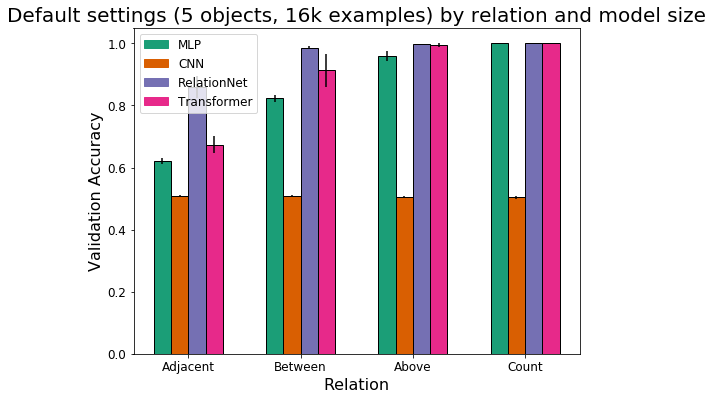

In [42]:
create_bar_chart(all_results_fixed_checkpoints_df, 
                 filter_dict=dict(model_config='default', num_objects=5, dataset_power=14), 
                 group_by_fields=('relation', 'model_name'),
                 metric='max_val_acc',
                 save_path='default_5_16k_group_by_relation.pdf',
                 title='Default settings (5 objects, 16k examples) by relation and model size')


/Users/guydavidson/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.


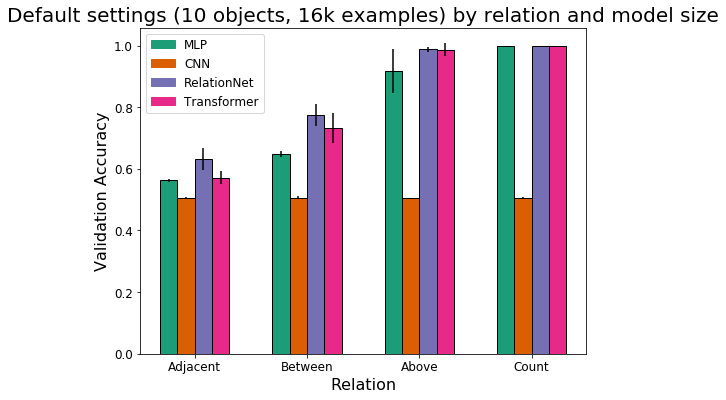

In [43]:
create_bar_chart(all_results_fixed_checkpoints_df, 
                 filter_dict=dict(model_config='default', num_objects=10, dataset_power=14), 
                 group_by_fields=('relation', 'model_name'),
                 metric='max_val_acc',
                 save_path='default_5_16k_group_by_relation.pdf',
                 title='Default settings (10 objects, 16k examples) by relation and model size')


/Users/guydavidson/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.


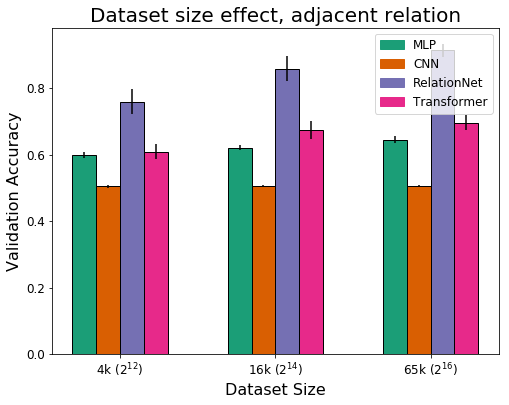

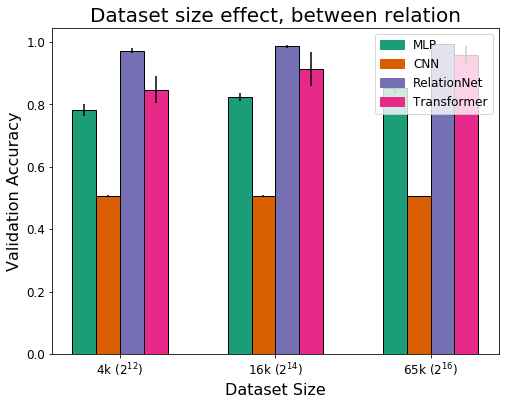

In [44]:
df = create_bar_chart(all_results_fixed_checkpoints_df, 
                 filter_dict=dict(model_config='default', num_objects=5, relation='adjacent'), 
                 group_by_fields=('dataset_size', 'model_name'),
                 metric='max_val_acc',
#                  save_path='default_5_adjacent_group_by_dataset_size.pdf',
                 title='Dataset size effect, adjacent relation')


create_bar_chart(all_results_fixed_checkpoints_df, 
                 filter_dict=dict(model_config='default', num_objects=5, relation='between'), 
                 group_by_fields=('dataset_size', 'model_name'),
                 metric='max_val_acc',
#                  save_path='default_5_adjacent_group_by_dataset_size.pdf',
                 title='Dataset size effect, between relation')


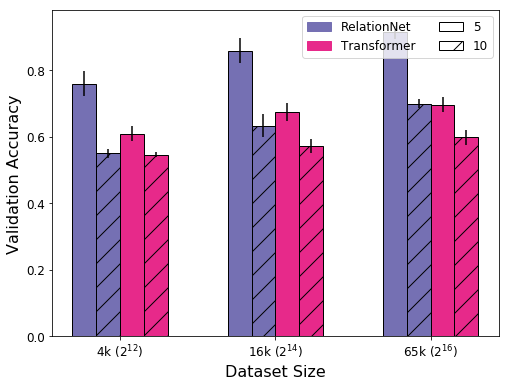

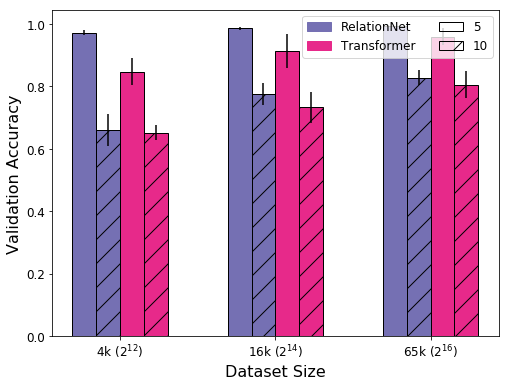

In [45]:
create_bar_chart(all_results_fixed_checkpoints_df, 
                 filter_dict=dict(model_config='default', relation='adjacent',
                                  model_name=['relation-net', 'transformer']), 
                 group_by_fields=['dataset_size', 'model_name', 'num_objects'],
                 metric='max_val_acc',
                 save_path='default_adjacent_group_by_dataset_size_and_num_objects.pdf'
                )


create_bar_chart(all_results_fixed_checkpoints_df, 
                 filter_dict=dict(model_config='default', relation='between',
                                  model_name=['relation-net', 'transformer']), 
                 group_by_fields=['dataset_size', 'model_name', 'num_objects'],
                 metric='max_val_acc',
                 save_path='default_between_group_by_dataset_size_and_num_objects.pdf'
                )



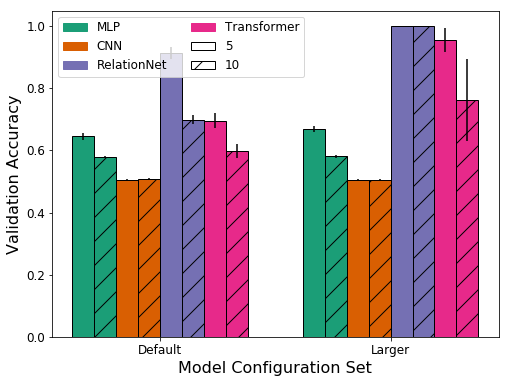

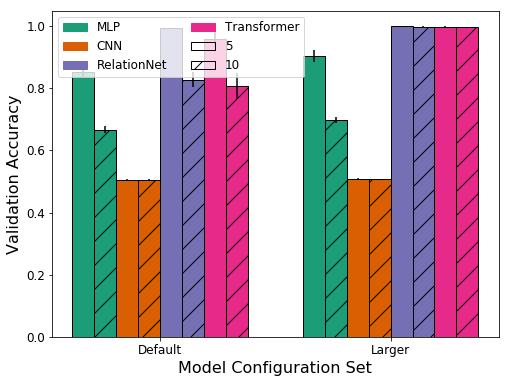

In [48]:
create_bar_chart(all_results_fixed_checkpoints_df, 
                 filter_dict=dict(relation='adjacent', dataset_power=16,
#                                   model_name=['relation-net', 'transformer']
                                 ), 
                 group_by_fields=['model_config', 'model_name', 'num_objects'],
                 metric='max_val_acc',
                 save_path='adjacent_group_by_model_config_and_num_objects.pdf'
                )


create_bar_chart(all_results_fixed_checkpoints_df, 
                 filter_dict=dict(relation='between', dataset_power=16,
#                                   model_name=['relation-net', 'transformer']
                                 ), 
                 group_by_fields=['model_config', 'model_name', 'num_objects'],
                 metric='max_val_acc',
                 save_path='between_group_by_model_config_and_num_objects.pdf'
                )



# Make a big 'ol table

In [42]:
table_group_by_columns = ['model_config', 'num_objects', 'dataset_size', 'relation', 'model_name']
custom_sorted_res = all_results_df.copy()
custom_sorted_res['model_name'] = pd.Categorical(custom_sorted_res['model_name'], 
                                                 ['combined-object-mlp', 'cnn', 'relation-net', 'transformer'])
custom_sorted_res['relation'] = pd.Categorical(custom_sorted_res['relation'], 
                                                 ['adjacent', 'above', 'count'])

custom_sorted_res = custom_sorted_res.sort_values('model_name').sort_values('relation')

grouped = custom_sorted_res.groupby(table_group_by_columns, as_index=False)
mean = grouped.mean()
mean.to_latex('./figures/result_table.txt', 
              columns=table_group_by_columns + ['max_val_acc', 'acc_diff'],
              float_format='%.3f', index=False, bold_rows=True)

dataset_power  \
model_config num_objects dataset_size relation model_name                           
default      5           4096         above    cnn                           12.0   
                                               combined-object-mlp           12.0   
                                               relation-net                  12.0   
                                               transformer                   12.0   
                                      adjacent cnn                           12.0   
...                                                                           ...   
larger       10          65536        adjacent transformer                   16.0   
                                      count    cnn                           16.0   
                                               combined-object-mlp           16.0   
                                               relation-net                  16.0   
                                               transformer                   16.0   

                                                                     seed  \
model_config num_objects dataset_size relation model_name                   
default      5           4096         above    cnn                  104.5   
                                               combined-object-mlp  104.5   
                                               relation-net         104.5   
                                               transformer          104.5   
                                      adjacent cnn                  104.5   
...                                                                   ...   
larger       10          65536        adjacent transformer          104.5   
                                      count    cnn                  104.5   
                                               combined-object-mlp  104.5   
                                               relation-net         104.5   
                                               transformer          104.5   

                                                                    total_params  \
model_config num_objects dataset_size relation model_name                          
default      5           4096         above    cnn                       12546.0   
                                               combined-object-mlp        1466.0   
                                               relation-net               1722.0   
                                               transformer                 770.0   
                                      adjacent cnn                       12546.0   
...                                                                          ...   
larger       10          65536        adjacent transformer                7666.0   
                                      count    cnn                       34386.0   
                                               combined-object-mlp        3842.0   
                                               relation-net               8562.0   
                                               transformer                7666.0   

                                                                    max_val_acc  \
model_config num_objects dataset_size relation model_name                         
default      5           4096         above    cnn                     0.506396   
                                               combined-object-mlp     0.939337   
                                               relation-net            0.981805   
                                               transformer             0.986102   
                                      adjacent cnn                     0.503088   
...                                                                         ...   
larger       10          65536        adjacent transformer             0.700916   
                                      count    cnn                     0.505182   
                                     

In [16]:
all_results_df.head()

,relation,model_config,num_objects,dataset_size,dataset_power,model_name,seed,total_params,max_val_acc,max_val_acc_step,acc_threshold_step,acc_diff
0,count,larger,10,65536,16,cnn,109,34386,0.505615,1279,NaN,0.270279
1,count,larger,10,65536,16,cnn,108,34386,0.503906,319,NaN,0.234879
2,count,larger,10,65536,16,cnn,103,34386,0.501831,191,NaN,0.216309
3,count,larger,10,65536,16,cnn,104,34386,0.503723,575,NaN,0.227295
4,count,larger,10,65536,16,cnn,101,34386,0.505188,575,NaN,0.227631


In [18]:
all_results_df[all_results_df.model_name != 'cnn'].acc_diff.max()

0.0469818115234375

In [19]:
all_results_df.acc_diff.max()

0.3663330078125

In [57]:
all_results_df[all_results_df.model_name == 'cnn'].acc_diff.max()

0.3663330078125

In [45]:
r = all_results_df[all_results_df.model_config == 'larger']
r.head()
# r = r[r.model_name.is != 'cnn']
# r = r[r.model_name != 'combined-object-mlp']
# r.loc[r.max_val_acc.idxmin()]

,relation,model_config,num_objects,dataset_size,dataset_power,model_name,seed,total_params,max_val_acc,max_val_acc_step,acc_threshold_step,acc_diff
0,count,larger,10,65536,16,cnn,109,34386,0.505615,1279,NaN,0.270279
1,count,larger,10,65536,16,cnn,108,34386,0.503906,319,NaN,0.234879
2,count,larger,10,65536,16,cnn,103,34386,0.501831,191,NaN,0.216309
3,count,larger,10,65536,16,cnn,104,34386,0.503723,575,NaN,0.227295
4,count,larger,10,65536,16,cnn,101,34386,0.505188,575,NaN,0.227631


In [46]:
r.num_objects.unique()

array([10,  5])

In [47]:
r.dataset_size.unique()

array([65536])

In [48]:
r.relation.unique()

array(['count', 'above', 'adjacent'], dtype=object)

In [50]:
all_results_df.groupby(['model_config', 'model_name']).total_params.mean()

model_config  model_name         
default       cnn                    12546
              combined-object-mlp     1466
              relation-net            1722
              transformer              770
larger        cnn                    34386
              combined-object-mlp     3842
              relation-net            8562
              transformer             7666
Name: total_params, dtype: int64

In [ ]:
partial_df.groupby('model_name').mean()

In [ ]:
for relation in ('adjacent', 'above', 'count'):
    d = partial_df[partial_df['relation'] == relation]
    print(d.head())
    print(d.groupby('model_name').max_val_acc.mean())

In [ ]:
partial_df.groupby(['relation', 'model_name']).mean()

In [ ]:
'hello world'.title()

In [ ]:
partial_df.head()

In [ ]:
partial_df.tail()

In [ ]:
d = all_results_df.copy()

In [ ]:
e = d[d['relation'].eq('adjacent')]

In [ ]:
d.shape, e.shape

In [ ]:
g = e.groupby(['num_objects', 'model_name'])

In [ ]:
np.sqrt(g['relation'].count())

In [ ]:
r = g.max_val_acc.mean()

In [ ]:
r.index.unique()

In [ ]:
r.loc[(5, 'cnn')]

In [ ]:
r.index.get_level_values('num_objects')

In [ ]:
history_df = r.history(samples=10000)

In [ ]:
history_df.columns

In [ ]:
history_df.val_acc.idxmax()

In [ ]:
history_df.iloc[3545]

In [ ]:
history_df.iloc[:25]

In [ ]:
2 => 1
5 => 2
8 => 3

In [ ]:
h2 = runs[28].history()
h2[:20]

In [ ]:
h2.val_acc.isnull().sum()

In [ ]:
history_df.val_acc[:501].isnull().sum()

In [ ]:
(h2.val_acc > 0.8).idxmax()

In [ ]:
h2.train_acc.max() - h2.val_acc.max()

In [51]:
run = api.run('simple-relational-reasoning-fixed-checkpoints/adjacent-relation-larger-models-10-objects-65536-dataset/oggkyfes')

In [57]:
files = run.files()

In [59]:
[f for f in files]

[<File config.yaml ()>,
 <File output.log (text/plain; charset=utf-8)>,
 <File relation-net-108-epoch=62-val_loss=0.000.ckpt ()>,
 <File requirements.txt (text/plain; charset=utf-8)>,
 <File wandb-metadata.json (application/json)>,
 <File wandb-summary.json (application/json)>]

In [62]:
f = files[0]

In [68]:
f = list(filter(lambda f: f.name.endswith('.ckpt'), files))[0]

In [71]:
f.download?

In [72]:
f.name

'relation-net-108-epoch=62-val_loss=0.000.ckpt'